In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import types

import data_jat as data


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
def weighted_avg(data, axis=0, weights=None, unc=False):
    """From Jon.  (Thanks Jon.)"""
    if weights is None:
        weights = np.empty(shape=data.shape, dtype=np.float64)
        weights.fill(1.)
    else:
        weights = weights.copy()
    data = data.copy()
    
    # Make NaN "disappear" from weights and input
    nanidx = np.isnan(data)
    weights[nanidx] = 0
    data[nanidx] = 0
    
    if unc:
        data = data ** 2
    sum_ = np.sum(data * weights, axis=axis)
    counts = np.sum(weights, axis=axis)
    
    if unc:
        sum_ = np.sqrt(sum_)
        
    # If there are no counts after averaging, then nan the output
    if len(sum_.shape) > 0:
        nocountidx = (counts == 0)
        counts[nocountidx] = 1
        sum_[nocountidx] = np.nan
    mean = sum_ / counts
    
    return mean


In [3]:
background = data.Data('joyce-apj-background')
background.read_data(force_cache=True)


Found cached data from file eventdata_joyce-apj-background_20210420.pickle3.bz2, using contents...


In [4]:
l = list()
r = list()
u = list()


for i, event in enumerate(background.eventdata):
    e = types.SimpleNamespace(**copy.deepcopy(event['ChanP']))
    
    lookdir_idx = np.zeros((80), dtype=bool)
    lookdir_idx[20:50] = True
    lookdir_idx[np.array((25, 31, 34, 35, 44))] = False    
    
    fluxbad = np.isnan(e.flux)
    fluxbad = np.min(fluxbad[:, lookdir_idx, :], axis=1)
    fluxbad = np.min(fluxbad, axis=1)
    fluxgood = ~fluxbad

    l.append(np.sum(e.epoch_delta[fluxgood]) * 2)

    """
    From Colin:
    
    > -For each energy bin and look direction, do the sum of (flux * delta t)
    > over the entire quiet period, then divide by the total time of the quiet
    > period (including the half delta-t at each end?) Is there any fill in
    > the flux for this? Dividing by the total time if some time bins are fill
    > would tend to decrease the flux (treating fill as zero).

    Correct. I believe at that time, I did treat fills as zeros rather than removing the
    points, which would have been better.
    """
    # weighted average in time
    weights = e.epoch_delta
    # make weights the right dimensionality
    weights = np.tile(weights[:, None, None], (1,) + e.flux.shape[1:])
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, weighted_avg(getattr(e, a), weights=weights, axis=0))
    weights_unc = weights / np.nanmean(weights)
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc'), weights=weights_unc, axis=0, unc=True))
   
    # make sure the time axis is gone:
    assert(len(e.flux.shape) == 2)
    
    # get only lookdirs of interest and do lookdir average
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, np.nanmean(getattr(e, a)[lookdir_idx, :], axis=0))
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc')[lookdir_idx, :], axis=0, unc=True))
        
    # make sure the lookdir axis is gone:
    assert(len(e.flux.shape) == 1)
    
    r.append(e.flux * 1e3)  # times 1e3 to go from per keV to per MeV
    u.append(e.flux_unc * 1e3)

    
# calculate mean flux and error; need to reshape some stuff for weights/binning
r = np.stack(r, axis=0)
u = np.stack(u, axis=0)
    
w = np.array(l)
w = w / np.nanmean(w)
w = np.tile(w[:, None], (1,) + u.shape[1:])

background_avg = weighted_avg(r, weights=w, axis=0)
background_err = weighted_avg(u, axis=0, weights=w, unc=True)
# grab the most recent bins because they're all the same anyway (at least they should be)
background_ebins = e.energy[0, 0, :]


/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


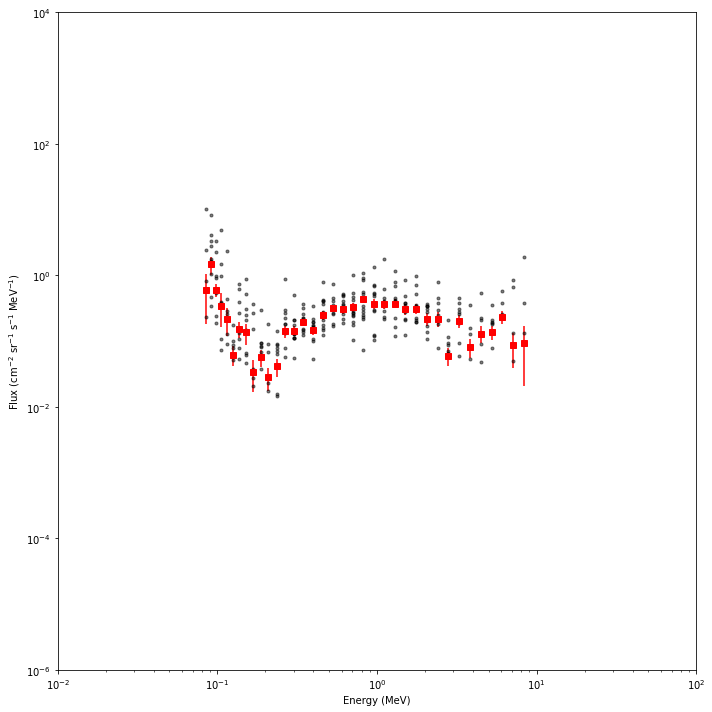

In [5]:
plt.figure(figsize=(10, 10))
plt.xlabel('Energy (MeV)')
plt.xscale('log')
plt.xlim(10e-3, 1e2)
plt.ylabel('Flux (cm$^{-2}$ sr$^{-1}$ s$^{-1}$ MeV$^{-1})$')
plt.yscale('log')
plt.ylim(1e-6, 1e4)

for f in r:
    plt.plot(background_ebins / 1e3, f, '.k', alpha=0.5)  # already scaled by 1e3
plt.errorbar(background_ebins / 1e3, background_avg, yerr=background_err, fmt='rs')

plt.tight_layout()

plt.savefig('figures/joyce-apj-fig1-closecolors.png', dpi=600)
plt.show()


In [6]:
for i, f in enumerate(r):
    print('{:8.2e} +/- {:8.2e}'.format(weighted_avg(f), weighted_avg(u[i], unc=True)))


2.53e-01 +/- 3.94e-02
1.41e-01 +/- 4.32e-02
3.99e-01 +/- 8.55e-02
1.39e-01 +/- 2.74e-02
2.63e-01 +/- 5.95e-02
1.22e-01 +/- 3.09e-02
8.91e-01 +/- 3.49e-01
2.18e-01 +/- 6.80e-02
2.31e-01 +/- 5.04e-02
2.09e-01 +/- 2.44e-02
2.29e-01 +/- 7.42e-02
1.51e-01 +/- 1.46e-02
1.81e-01 +/- 2.08e-02


In [7]:
events = data.Data('joyce-apj-events')
events.read_data()

quiettimes = data.Data('joyce-apj-event-quiettimes')
quiettimes.read_data()


Found cached data from file eventdata_joyce-apj-events_20210707.pickle3.bz2, using contents...
Found cached data from file eventdata_joyce-apj-event-quiettimes_20210707.pickle3.bz2, using contents...
